In [22]:
import pandas as pd
import os

# get parent dir
parent_dir = os.path.dirname(os.getcwd())

# load the dataset
df = pd.read_csv(os.path.join(
    parent_dir, 'dm2_dataset_2425_imdb',
    'imdb_ts.csv'))

In [23]:
df['genre'] = df['genre'].apply(lambda x: x.split(',') if pd.notna(x) else x)
# clean genre column from [, ], '
df['genre'] = df['genre'].apply(
    lambda x: [i.strip().replace("'", "").replace("[", "").replace("]", "") for i in x] if isinstance(x, list) else x
)
df['genre']

0               [Adventure, Sci-Fi]
1           [Crime, Drama, Romance]
2              [Documentary, Music]
3       [Action, Adventure, Sci-Fi]
4        [Adventure, Comedy, Drama]
                   ...             
1129    [Horror, Mystery, Thriller]
1130     [Biography, Comedy, Drama]
1131     [Comedy, Horror, Thriller]
1132    [Biography, Drama, History]
1133     [Biography, Comedy, Drama]
Name: genre, Length: 1134, dtype: object

In [24]:
# Compute frequency encoding for each genre
from collections import Counter
genre_counts = Counter(genre for sublist in df['genre'].dropna() for genre in sublist)
genre_freq = {genre: count / len(df) for genre, count in genre_counts.items()}

genre_freq

{'Adventure': 0.31569664902998235,
 'Sci-Fi': 0.08818342151675485,
 'Crime': 0.13051146384479717,
 'Drama': 0.48677248677248675,
 'Romance': 0.09700176366843033,
 'Documentary': 0.023809523809523808,
 'Music': 0.03439153439153439,
 'Action': 0.3165784832451499,
 'Comedy': 0.35978835978835977,
 'Fantasy': 0.07583774250440917,
 'Thriller': 0.14109347442680775,
 'History': 0.05555555555555555,
 'War': 0.010582010582010581,
 'Animation': 0.10493827160493827,
 'Biography': 0.13051146384479717,
 'Horror': 0.11199294532627865,
 'Mystery': 0.08818342151675485,
 'Family': 0.0582010582010582,
 'Sport': 0.021164021164021163,
 'Musical': 0.010582010582010581,
 'Short': 0.001763668430335097,
 'Western': 0.001763668430335097}

In [25]:
# convert genre column into genre1, genre2, genre3 columns, sorting on frequency
df['genre'] = df['genre'].apply(lambda x: sorted(x, key=lambda y: genre_freq.get(y, 0), reverse=True) if isinstance(x, list) else x)

genre_cols = ['genre1', 'genre2', 'genre3']

df[genre_cols] = pd.DataFrame(df['genre'].tolist(), index=df.index).iloc[:, :3]
df = df.drop(columns=['genre'])

In [26]:
# convert genre columns into frequency encoding
df['genre1'] = df['genre1'].map(genre_freq)
df['genre2'] = df['genre2'].map(genre_freq)
df['genre3'] = df['genre3'].map(genre_freq)

In [27]:
df = df.fillna(0)

df[genre_cols].head()

,genre1,genre2,genre3
0,0.315697,0.088183,0.000000
1,0.486772,0.130511,0.097002
2,0.034392,0.023810,0.000000
3,0.316578,0.315697,0.088183
4,0.486772,0.359788,0.315697


In [28]:
df.groupby('rating_category').size()

rating_category
High           377
Low             10
Medium         387
Medium High    232
Medium Low     128
dtype: int64

In [29]:
# merge Medium Low and Low into a single category
df['rating_category'] = df['rating_category'].replace({
    'Medium Low': 'Low'
})

In [30]:
# 80-20 stratified split
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df['rating_category'], random_state=42
)

# further split train into train and val
train_df, val_df = train_test_split(
    train_df, test_size=0.25, stratify=train_df['rating_category'], random_state=42
)

X_train = train_df.drop(columns=['id', 'rating', 'rating_category'])
y_train = train_df['rating_category']

X_val = val_df.drop(columns=['id', 'rating', 'rating_category'])
y_val = val_df['rating_category']

X_test = test_df.drop(columns=['id', 'rating', 'rating_category'])
y_test = test_df['rating_category']

In [31]:
# Log scale transformation only for columns '0', '1', ... '99' (TS columns)
import numpy as np

ts_columns = [str(i) for i in range(100)]
X_train[ts_columns] = X_train[ts_columns].applymap(lambda x: np.log1p(x))
X_val[ts_columns] = X_val[ts_columns].applymap(lambda x: np.log1p(x))
X_test[ts_columns] = X_test[ts_columns].applymap(lambda x: np.log1p(x))

/var/folders/68/gjrvx3m51494g9gp2r93j3vh0000gn/T/ipykernel_70158/1279882901.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_train[ts_columns] = X_train[ts_columns].applymap(lambda x: np.log1p(x))
/var/folders/68/gjrvx3m51494g9gp2r93j3vh0000gn/T/ipykernel_70158/1279882901.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_val[ts_columns] = X_val[ts_columns].applymap(lambda x: np.log1p(x))
/var/folders/68/gjrvx3m51494g9gp2r93j3vh0000gn/T/ipykernel_70158/1279882901.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_test[ts_columns] = X_test[ts_columns].applymap(lambda x: np.log1p(x))


In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [33]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc = label_encoder.transform(y_val)
y_test_enc = label_encoder.transform(y_test)

In [34]:
import tensorflow as tf

In [35]:
from tensorflow.keras.utils import to_categorical

y_train_enc = to_categorical(y_train_enc)
y_val_enc = to_categorical(y_val_enc)
y_test_enc = to_categorical(y_test_enc)

In [36]:
# Split X into ts and genre
X_train = {
    'ts_1': X_train[:, :50].reshape(-1, 50, 1),
    'ts_2': X_train[:, 50:100].reshape(-1, 50, 1),
    'genre': X_train[:, 100:103]
}
X_val = {
    'ts_1': X_val[:, :50].reshape(-1, 50, 1),
    'ts_2': X_val[:, 50:100].reshape(-1, 50, 1),
    'genre': X_val[:, 100:103]
}
X_test = {
    'ts_1': X_test[:, :50].reshape(-1, 50, 1),
    'ts_2': X_test[:, 50:100].reshape(-1, 50, 1),
    'genre': X_test[:, 100:103]
}

In [37]:
from json import encoder
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Bidirectional, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam

# Genre branch
genre_input = Input(shape=(3,), name='genre')
genre_branch = Dense(8, activation='relu')(genre_input)
genre_branch = BatchNormalization()(genre_branch)

# Encoder
encoder_input = Input(shape=(50, 1), name='ts_1')
encoder_branch = Bidirectional(LSTM(
    32,
    return_sequences=True,
    recurrent_dropout=0.4
))(encoder_input)
encoder_branch = BatchNormalization()(encoder_branch)
_, h_fwd, c_fwd, h_bwd, c_bwd = Bidirectional(LSTM(
    64,
    return_state=True,
    recurrent_dropout=0.4
))(encoder_branch)

# Decoder
decoder_input = Input(shape=(50, 1), name='ts_2')
decoder_branch = Bidirectional(LSTM(
    64,
    return_sequences=True,
    recurrent_dropout=0.4
))(decoder_input, initial_state=[h_fwd, c_fwd, h_bwd, c_bwd])
decoder_branch = BatchNormalization()(decoder_branch)
decoder_branch = Bidirectional(LSTM(
    32,
    return_sequences=False,
    recurrent_dropout=0.4
))(decoder_branch)
decoder_branch = BatchNormalization()(decoder_branch)


# Concatenate genre branch with decoder output
concatenated = Concatenate()([decoder_branch, genre_branch])
concatenated = Dense(64)(concatenated)
concatenated = BatchNormalization()(concatenated)
concatenated = Activation('relu')(concatenated)
concatenated = Dropout(0.4)(concatenated)

output = Dense(4, activation='softmax')(concatenated)
model2 = Model(inputs=[encoder_input, decoder_input, genre_input], outputs=output)
model2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
from pyexpat import model
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf

weights_2 = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

weights_2 = dict(enumerate(weights_2))

# Train the model
history_2 = model2.fit(
    X_train,
    y_train_enc,
    validation_data=(
        X_val,
        y_val_enc
    ),
    epochs=200,
    batch_size=32,
    verbose=1,
    class_weight=weights_2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True,
            # start_from_epoch=50
        )
    ]
)

Epoch 1/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.3397 - loss: 1.5570 - val_accuracy: 0.3348 - val_loss: 1.3470
Epoch 2/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.3824 - loss: 1.3900 - val_accuracy: 0.3392 - val_loss: 1.3257
Epoch 3/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.3515 - loss: 1.3923 - val_accuracy: 0.3524 - val_loss: 1.3046
Epoch 4/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.3824 - loss: 1.3799 - val_accuracy: 0.3568 - val_loss: 1.2848
Epoch 5/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.3676 - loss: 1.2946 - val_accuracy: 0.3568 - val_loss: 1.2754
Epoch 6/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.3706 - loss: 1.3322 - val_accuracy: 0.3656 - val_loss: 1.2447
Epoch 7/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.3779 - loss: 1.2906 - val_accuracy: 0.4009 - val_loss: 1.2245
Epoch 8/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.3941 - loss: 1.2651 - val_accuracy: 0.

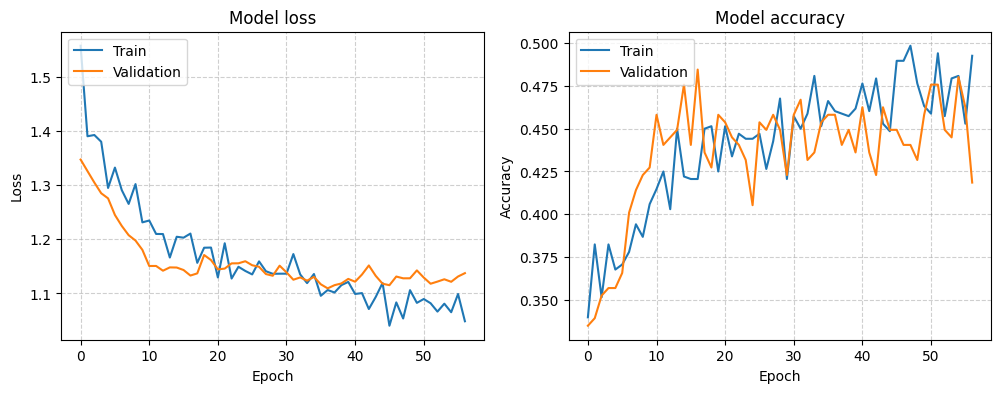

In [39]:
# Plot training & validation accuracy values
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(linestyle='--', alpha=0.6)
# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(linestyle='--', alpha=0.6)
plt.show()

In [40]:
# evaluate the model
test_loss_2, test_accuracy_2 = model2.evaluate(
    X_test,
    y_test_enc,
    verbose=0
)

In [41]:
# sort the labels as Low, Medium, Medium High, High
labels = ['Low', 'Medium', 'Medium High', 'High']

# classification report
from sklearn.metrics import classification_report
print(f'Test Accuracy: {test_accuracy_2:.4f}')
y_pred_probs = model2.predict(
    X_test
)
y_pred = label_encoder.inverse_transform(np.argmax(y_pred_probs, axis=1))
print(classification_report(y_test, y_pred, labels=labels))

Test Accuracy: 0.4449
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
              precision    recall  f1-score   support

         Low       0.31      0.50      0.38        28
      Medium       0.52      0.44      0.47        78
 Medium High       0.30      0.35      0.32        46
        High       0.59      0.49      0.54        75

    accuracy                           0.44       227
   macro avg       0.43      0.44      0.43       227
weighted avg       0.47      0.44      0.45       227



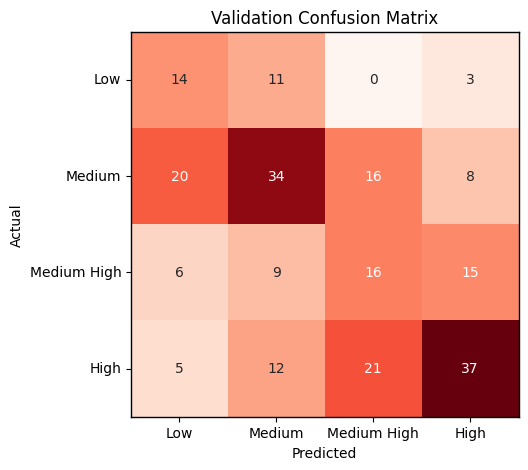

In [44]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm_val = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=labels)

plt.figure(figsize=(5, 5))
ax = sns.heatmap(
    cm_val, annot=True, fmt='d',
    xticklabels=labels,
    yticklabels=labels,
    cmap='Reds', cbar=False,
)

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.yticks(rotation=0)
plt.title('Validation Confusion Matrix')

# --- Add black outer border ---
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)
# --------------------------------

plt.show()

In [ ]:
# Build new model for visualization while hiding BatchNormalization and Dropout layers for clarity
from os import name


genre_input = Input(shape=(3,), name='genre input')
genre_branch = Dense(8, activation='relu', name='Dense Genre 8')(genre_input)
# genre_branch = BatchNormalization()(genre_branch)

# Encoder
encoder_input = Input(shape=(50, 1), name='encoder input')
encoder_branch = Bidirectional(LSTM(
    32,
    return_sequences=True,
    recurrent_dropout=0.3,
    name='Encoder LSTM 32'
), name='Enc Bidir LSTM 32')(encoder_input)
# encoder_branch = BatchNormalization()(encoder_branch)
_, h_fwd, c_fwd, h_bwd, c_bwd = Bidirectional(LSTM(
    64,
    return_state=True,
    recurrent_dropout=0.3,
    name='Encoder LSTM 64'
), name='Enc Bidir LSTM 64')(encoder_branch)

# Decoder
decoder_input = Input(shape=(50, 1), name='decoder input')
decoder_branch = Bidirectional(LSTM(
    64,
    return_sequences=True,
    recurrent_dropout=0.3,
    name='Decoder LSTM 64'
), name='Dec Bidir LSTM 64')(decoder_input, initial_state=[h_fwd, c_fwd, h_bwd, c_bwd])
# decoder_branch = BatchNormalization()(decoder_branch)
decoder_branch = Bidirectional(LSTM(
    32,
    return_sequences=False,
    recurrent_dropout=0.3,
    name='Dec LSTM 32'
), name='Dec Bidir LSTM 32')(decoder_branch)
# decoder_branch = BatchNormalization()(decoder_branch)


# Concatenate genre branch with decoder output
concatenated = Concatenate(name='Concatenation')([decoder_branch, genre_branch])
concatenated = Dense(64, activation='relu', name='Dense 64')(concatenated)
# concatenated = BatchNormalization()(concatenated)
# concatenated = Dropout(0.3)(concatenated)

output = Dense(4, activation='softmax', name='Output layer')(concatenated)
model_vis = Model(inputs=[encoder_input, decoder_input, genre_input], outputs=output)
model_vis.compile(optimizer=Adam(learning_rate=0.005), loss='categorical_crossentropy', metrics=['accuracy'])

: 

: 

: 

: 

: 

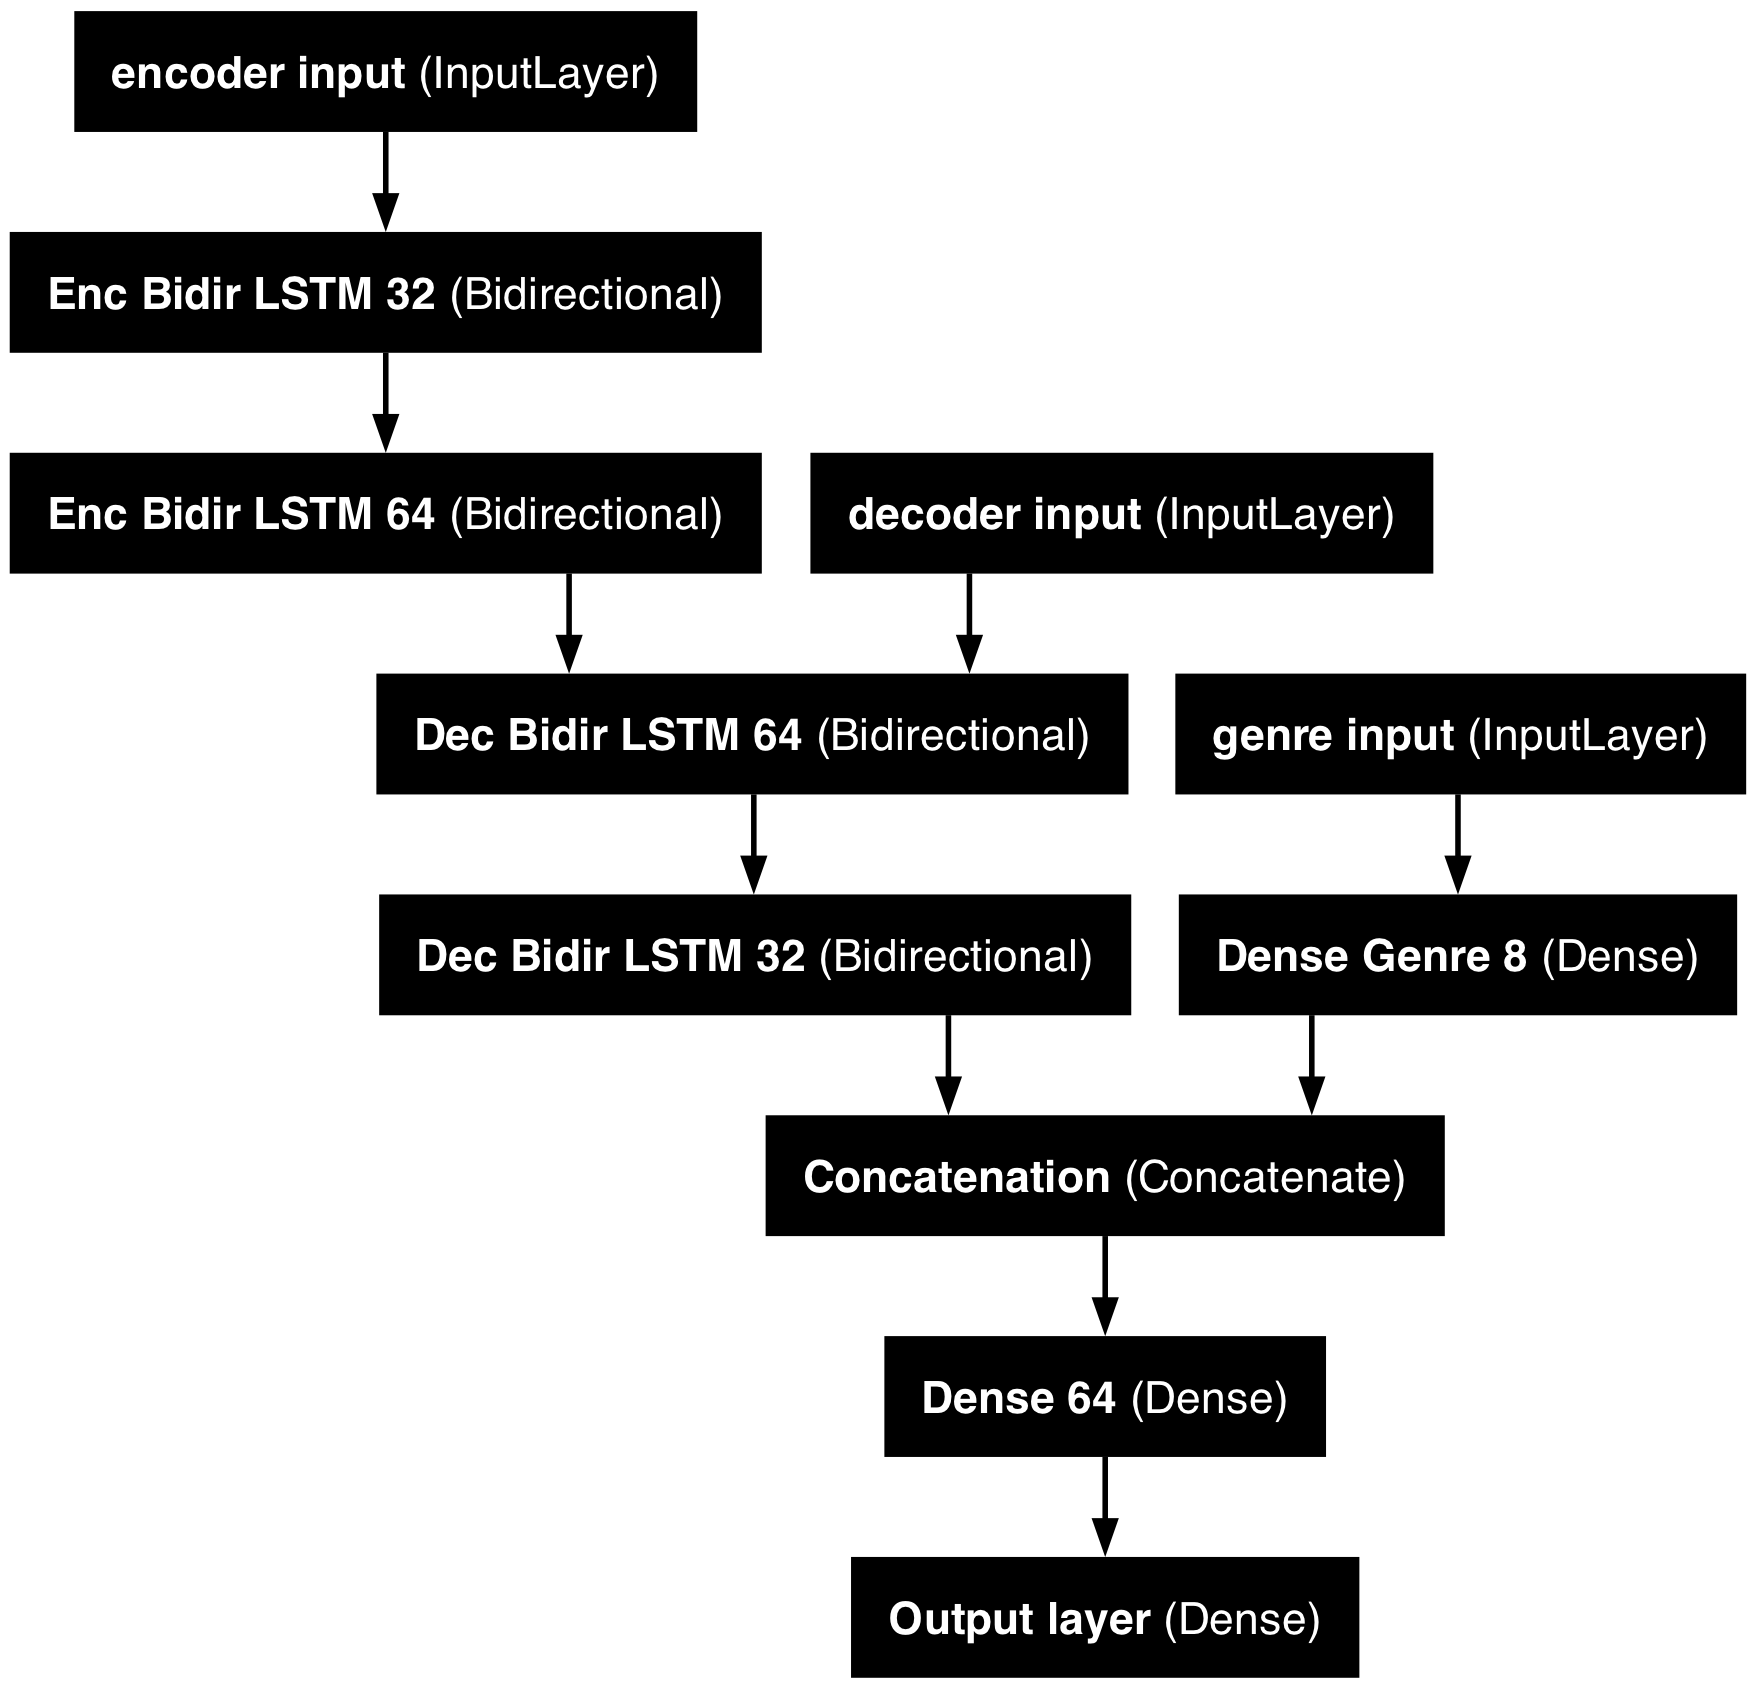

: 

: 

: 

: 

: 

In [ ]:
# Plot model architecture

from scipy.__config__ import show
from tensorflow.keras.utils import plot_model

# Group LSTM layers with their corresponding Dropout layers using nested blocks in the plot
# Hide BatchNormalization and Dropout layers for clarity
plot_model(
    model_vis,
    to_file='rnn_model.png',
    show_shapes=False,
    show_layer_names=True,
    expand_nested=True,
    # show_layer_types=False
)

In [ ]:
# # Save model
# model2.save('rnn_model.keras')

: 

: 

: 

: 

: 

In [ ]:
# train_decomp.head()

: 

: 

: 

: 

In [ ]:
# # Standard scale the components
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# train_trend_scaled = scaler.fit_transform(pd.DataFrame(train_decomp['trend'].tolist()))
# train_seasonal_scaled = scaler.fit_transform(pd.DataFrame(train_decomp['seasonal'].tolist()))
# train_residual_scaled = scaler.fit_transform(pd.DataFrame(train_decomp['residual'].tolist()))

# train_merge = pd.DataFrame({
#     'trend': list(train_trend_scaled),
#     'seasonal': list(train_seasonal_scaled),
#     'residual': list(train_residual_scaled)
# })

# val_trend_scaled = scaler.transform(pd.DataFrame(val_decomp['trend'].tolist()))
# val_seasonal_scaled = scaler.transform(pd.DataFrame(val_decomp['seasonal'].tolist()))
# val_residual_scaled = scaler.transform(pd.DataFrame(val_decomp['residual'].tolist()))

# val_merge = pd.DataFrame({
#     'trend': list(val_trend_scaled),
#     'seasonal': list(val_seasonal_scaled),
#     'residual': list(val_residual_scaled)
# })


# test_trend_scaled = scaler.transform(pd.DataFrame(test_decomp['trend'].tolist()))
# test_seasonal_scaled = scaler.transform(pd.DataFrame(test_decomp['seasonal'].tolist()))
# test_residual_scaled = scaler.transform(pd.DataFrame(test_decomp['residual'].tolist()))

# test_merge = pd.DataFrame({
#     'trend': list(test_trend_scaled),
#     'seasonal': list(test_seasonal_scaled),
#     'residual': list(test_residual_scaled)
# })

: 

: 

: 

: 

In [ ]:
# # Build a RNN model using Keras
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Add
# from tensorflow.keras.utils import to_categorical
# from sklearn.preprocessing import LabelEncoder
# from tensorflow.keras.optimizers import Adam

# # Encode labels
# label_encoder = LabelEncoder()
# y_train_enc = to_categorical(label_encoder.fit_transform(y_train))
# y_val_enc = to_categorical(label_encoder.transform(y_val))
# y_test_enc = to_categorical(label_encoder.transform(y_test))

# # Define model
# def build_rnn_model(residuals_shape, seasonality_shape, trend_shape, num_classes):
#     # Residuals component
#     inputs_residuals = Input(shape=residuals_shape)
#     x = LSTM(64, return_sequences=False)(inputs_residuals)
#     # x = LSTM(32, return_sequences=True)(x)
#     # x = Dropout(0.2)(x)
#     # x = LSTM(16, return_sequences=False)(x)
#     x = Dropout(0.2)(x)
#     residuals_output = Dense(8, activation='relu')(x)
    
#     # Seasonality component
#     inputs_seasonal = Input(shape=seasonality_shape)
#     y = LSTM(64, return_sequences=False)(inputs_seasonal)
#     # y = LSTM(32, return_sequences=True)(y)
#     # y = Dropout(0.2)(y)
#     # y = LSTM(16, return_sequences=False)(y)
#     y = Dropout(0.2)(y)
#     seasonal_output = Dense(8, activation='relu')(y)
    
#     # Trend component
#     inputs_trend = Input(shape=trend_shape)
#     z = LSTM(64, return_sequences=False)(inputs_trend)
#     # z = LSTM(32, return_sequences=True)(z)
#     # z = Dropout(0.2)(z)
#     # z = LSTM(16, return_sequences=False)(z)
#     z = Dropout(0.2)(z)
#     trend_output = Dense(8, activation='relu')(z)
    
    
#     # Combine all components using the functional API's Add layer
#     combined_tensor = Add()([residuals_output, seasonal_output, trend_output])
#     # Final dense layers for classification
#     d = Dense(16, activation='relu')(combined_tensor)
#     d = Dropout(0.3)(d)
#     d = Dense(32, activation='relu')(d)
#     d = Dropout(0.3)(d)
#     d = Dense(16, activation='relu')(d)
#     d = Dropout(0.3)(d)
    
#     outputs = Dense(num_classes, activation='softmax')(d)
    
#     model = Model(inputs=[inputs_residuals, inputs_seasonal, inputs_trend], outputs=outputs)
#     model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
#     return model

: 

: 

: 

: 

In [ ]:
# model = build_rnn_model(
#     residuals_shape=(100, 1),
#     seasonality_shape=(100, 1),
#     trend_shape=(100, 1),
#     num_classes=y_train_enc.shape[1]
# )
# model.summary()

: 

: 

: 

: 

In [ ]:
# from sklearn.utils.class_weight import compute_class_weight

# weights = compute_class_weight(
#     class_weight="balanced",
#     classes=np.unique(y_train),
#     y=y_train
# )

# weights = dict(enumerate(weights))

# # Train the model
# history = model.fit(
#     [train_residual_scaled.reshape(-1, 100, 1),
#      train_seasonal_scaled.reshape(-1, 100, 1),
#      train_trend_scaled.reshape(-1, 100, 1)],
#     y_train_enc,
#     validation_data=(
#         [val_residual_scaled.reshape(-1, 100, 1),
#          val_seasonal_scaled.reshape(-1, 100, 1),
#          val_trend_scaled.reshape(-1, 100, 1)],
#         y_val_enc
#     ),
#     class_weight=weights,
#     epochs=50,
#     batch_size=32,
#     verbose=1,
# )

# # Evaluate the model
# test_loss, test_accuracy = model.evaluate(
#     [test_residual_scaled.reshape(-1, 100, 1),
#      test_seasonal_scaled.reshape(-1, 100, 1),
#      test_trend_scaled.reshape(-1, 100, 1)],
#     y_test_enc,
#     verbose=0
# )
# print(f'Test Accuracy: {test_accuracy:.4f}')

: 

: 

: 

: 

In [ ]:
# # Plot training & validation accuracy values
# import matplotlib.pyplot as plt
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.grid(linestyle='--', alpha=0.6)
# # Plot training & validation loss values
# plt.subplot(1, 2, 2)
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')

# plt.grid(linestyle='--', alpha=0.6)
# plt.show()

: 

: 

: 

: 

In [ ]:
# # classification report
# from sklearn.metrics import classification_report, confusion_matrix

# y_pred_probs = model.predict(
#     [test_residual_scaled.reshape(-1, 100, 1),
#      test_seasonal_scaled.reshape(-1, 100, 1),
#      test_trend_scaled.reshape(-1, 100, 1)]
# )
# y_pred = label_encoder.inverse_transform(np.argmax(y_pred_probs, axis=1))
# print(classification_report(y_test, y_pred))

: 

: 

: 

: 

In [ ]:
# import seaborn as sns
# cm = confusion_matrix(y_test, y_pred, labels=label_encoder.classes_)
# plt.figure(figsize=(5, 5))
# sns.heatmap(cm, annot=True, fmt='d',
#             xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Reds', cbar=False)
# plt.ylabel('Actual')
# plt.xlabel('Predicted')
# plt.title('Confusion Matrix')
# plt.show()

: 

: 

: 

: 

In [ ]:
# # Plot ROC curves for each class

# from sklearn.metrics import roc_curve, auc
# from sklearn.preprocessing import label_binarize
# y_test_binarized = label_binarize(y_test, classes=label_encoder.classes_)
# n_classes = y_test_binarized.shape[1]
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(n_classes):
#     fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_probs[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])
# # Plot all ROC curves
# plt.figure(figsize=(6, 5))
# colors = ['blue', 'green', 'red', 'orange']
# for i, color in zip(range(n_classes), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=2,
#              label='ROC curve of class {0} (area = {1:0.2f})'
#              ''.format(label_encoder.classes_[i], roc_auc[i]))
# plt.plot([0, 1], [0, 1], 'k--', lw=2)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curves')
# plt.legend(loc="lower right")
# plt.grid(linestyle='--', alpha=0.6)
# plt.show()

: 

: 

: 

: 